In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import torch
from torch import nn
import captum
from utils import *
from models.cnn import CNN
from torchvision import transforms
from torchvision.transforms import ToTensor
%matplotlib inline

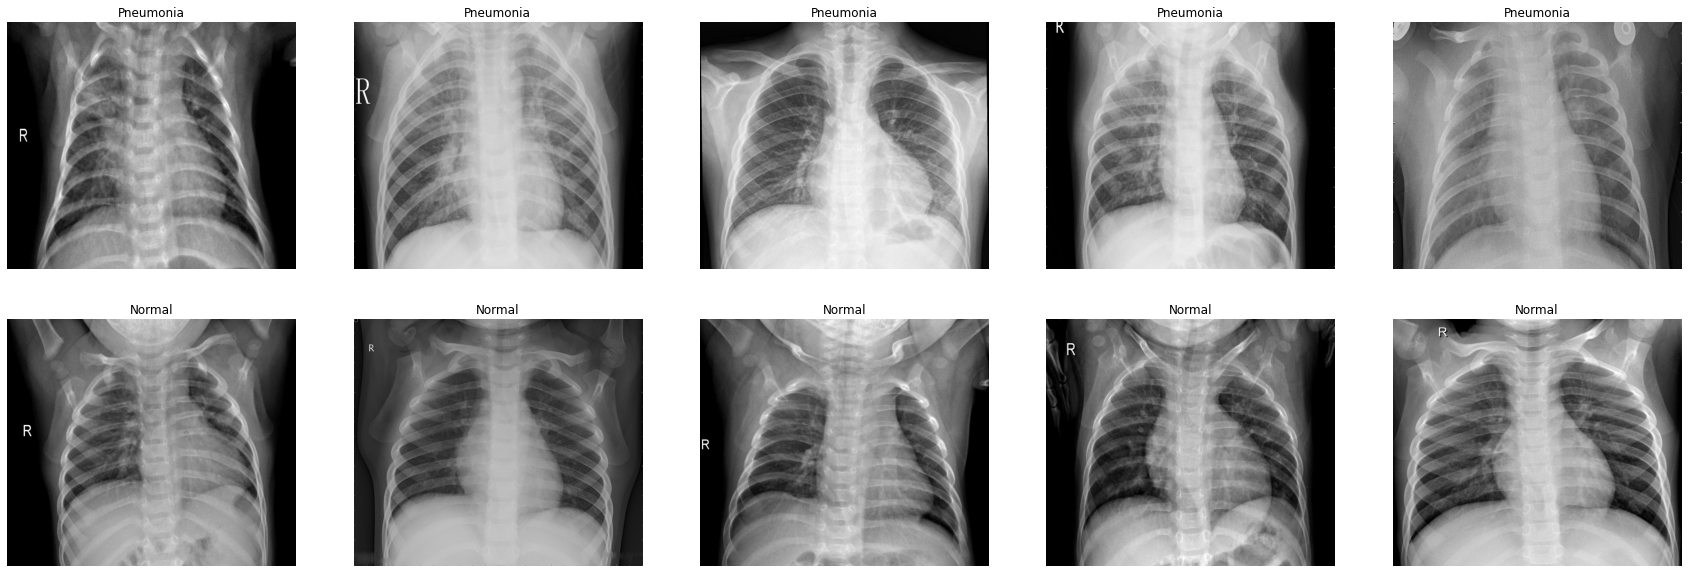

In [9]:
dataset = get_data()
pneumonia_samples = dataset[dataset['class']==1]['filename'].iloc[:5]
normal_samples = dataset[dataset['class']==0]['filename'].iloc[:5]

samples = pd.concat([pneumonia_samples, normal_samples]).to_list()

_, ax = plt.subplots(2,5, figsize=(30,10))
for i in range(10):
    img = cv2.imread(samples[i])
    ax[i//5, i%5].imshow(img, cmap='gray')
    if i<5:
        ax[i//5, i%5].set_title("Pneumonia")
    else:
        ax[i//5, i%5].set_title("Normal")
    ax[i//5, i%5].axis('off')
    ax[i//5, i%5].set_aspect('auto')
plt.show()

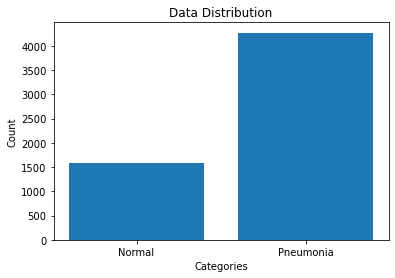

In [19]:
# Plot Image Distribution
categories = ['Normal', 'Pneumonia']
frequencies = list(dataset['class'].value_counts())[::-1]
plt.bar(categories, frequencies)
plt.xlabel("Categories")
plt.ylabel("Count")
plt.title('Data Distribution')
plt.show()

In [11]:
EPOCHS = 30
BATCH_SIZE = 32
LEARNING_RATE = 0.00175
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using the {DEVICE.type}')

Using the cpu


In [12]:
data_transforms = transforms.Compose([
    ToTensor(),
    transforms.RandomAffine(degrees=0, shear=0.2),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
])

In [13]:
train_split = dataset.iloc[:round(len(dataset) * 0.8)]
val_split = dataset.iloc[round(len(dataset) * 0.8): round(len(dataset) * 0.9)]
test_split = dataset.iloc[round(len(dataset) * 0.9):]

train_dataloader = get_dataloader(train_split, BATCH_SIZE, transform=data_transforms)
val_dataloader = get_dataloader(val_split, BATCH_SIZE)
test_dataloader = get_dataloader(test_split, BATCH_SIZE, shuffle=False)

In [17]:
model = CNN().to(DEVICE)
print(f"Model summary\n-------------------------------\n{model}")

Model summary
-------------------------------
CNN(
  (network): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=valid)
    (1): LeakyReLU(negative_slope=0.01)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.25, inplace=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=valid)
    (5): LeakyReLU(negative_slope=0.01)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.25, inplace=False)
    (8): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=valid)
    (9): LeakyReLU(negative_slope=0.01)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Dropout(p=0.25, inplace=False)
    (12): Flatten(start_dim=1, end_dim=-1)
    (13): Linear(in_features=64, out_features=512, bias=True)
    (14): Linear(in_features=512, out_features=1, bias=True)
    (15): Sigmoid()
  )
)


In [20]:
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

for t in range(EPOCHS):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer, device=DEVICE)
    evaluate(val_dataloader, model, loss_fn, device=DEVICE)
print("Done!")

Epoch 1
-------------------------------
loss: 0.703954  [    0/ 4685]
loss: 0.633937  [  320/ 4685]
loss: 0.461674  [  640/ 4685]
loss: 0.497199  [  960/ 4685]
loss: 0.608621  [ 1280/ 4685]
loss: 0.501724  [ 1600/ 4685]
loss: 0.664729  [ 1920/ 4685]
loss: 0.657637  [ 2240/ 4685]
loss: 0.638817  [ 2560/ 4685]
loss: 0.521075  [ 2880/ 4685]
loss: 0.182731  [ 3200/ 4685]
loss: 0.441386  [ 3520/ 4685]
loss: 0.388029  [ 3840/ 4685]
loss: 0.385987  [ 4160/ 4685]
loss: 0.312944  [ 4480/ 4685]
Test Error: 
 Accuracy: 84.3%, Avg loss: 0.332816 

Epoch 2
-------------------------------
loss: 0.397229  [    0/ 4685]
loss: 0.448419  [  320/ 4685]
loss: 0.334088  [  640/ 4685]
loss: 0.308907  [  960/ 4685]
loss: 0.376658  [ 1280/ 4685]
loss: 0.258822  [ 1600/ 4685]
loss: 0.244321  [ 1920/ 4685]
loss: 0.266751  [ 2240/ 4685]
loss: 0.142526  [ 2560/ 4685]
loss: 0.178200  [ 2880/ 4685]
loss: 0.351388  [ 3200/ 4685]
loss: 0.301131  [ 3520/ 4685]
loss: 0.719409  [ 3840/ 4685]
loss: 0.417390  [ 4160/ 4685

In [40]:
print('Evaluating on Test Data')
evaluate(test_dataloader, model, loss_fn)

Evaluating on Test Data
Test Error: 
 Accuracy: 94.0%, Avg loss: 0.172943


In [20]:
print('Saving Model')
save_model(model, './trained_models/best_model.pth')
print('Model Saved')

Saving Model
Model Saved
